# Step by step preprocessing

Fist, we need to import the packages. We will need nilearn (learning algorithms and image manipulation), pandas and numpy (data structures manipulation).

In [73]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import nilearn

from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn import masking
from nilearn.image import mean_img

from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel

from nilearn.plotting import plot_design_matrix

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

## Let's look at the raw data (i.e. data as acquired)

To start, we need to inform the software where are the data.


In [74]:
# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
ROOT_DATA='/home/brunomiguel/Documents/data/BIDS/'
SUB='sub-0001'
SES='ses-001'
RUN='run-01'

# data folder
data_path=os.path.join(ROOT_DATA, SUB, SES)
print('The data is in this folder - ' + data_path)

# project folder
ROOT_PROJECT="/Users/home/Documents/GitHub/MVPA-speech_project"



The data is in this folder - /home/brunomiguel/Documents/data/BIDS/sub-0001/ses-001


# Structural data.

## Raw data.

Let's look at the raw data.

/home/brunomiguel/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


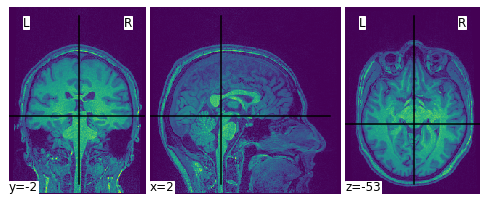

In [75]:
t1w_fp=os.path.join(data_path, 'anat', 
                           SUB + '_' + SES + '_run-01_T1w.nii.gz')
plotting.plot_img(t1w_fp)

First we used the FSL toolbox to preprocess the structural image. 

https://www.youtube.com/watch?v=VobRXk3ccNQ

BET - Brain extraction.
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide

(used default values - with Fractional intensity threshold of 0.5)

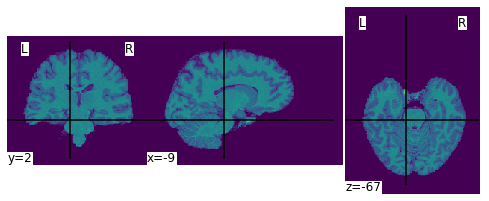

In [76]:
t1w_brain_fp=os.path.join(data_path, 'anat', SUB + '_' + SES + '_run-01_T1w.anat',
                                 'T1_biascorr_brain.nii.gz')

plotting.plot_img(t1w_brain_fp)

## Functional data preprocessing

Raw functional data.


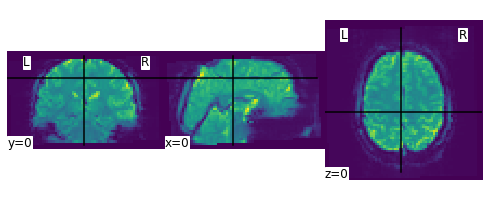

In [77]:
func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-nomeacaoinner_'+ RUN +'_bold.nii.gz')

# Mean image  to check motion correction.
m_img=mean_img(func_data_pp)
                          
# coordinates to place cross in mean image.
cut_coords=(0, 0, 0)

# Plot mean functional image.
plotting.plot_img(m_img, cut_coords)

Second step includes the FEAT - fMRI Expert Analysis Tool https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT.

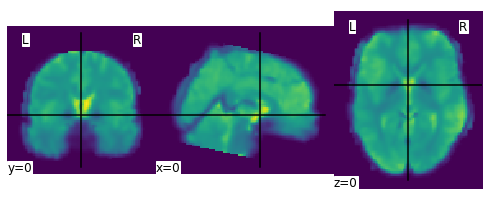

In [104]:
func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + '_task-nomeacaoinner_'+ RUN +'_bold_pp_standard.nii.gz')

# Mean image  to check motion correction.
m_img=mean_img(func_data_pp)

# Create a mask.
mask=masking.compute_epi_mask(m_img)
                          
# coordinates to place cross in mean image.
cut_coords=(0, 0, 0)

# Plot mean functional image.
plotting.plot_img(m_img, cut_coords)

We see the data smoothed and registered to MNI standard.

How many images do we have in this dataset?

In [105]:
func_d_img=image.load_img(func_data_pp)

func_d_img=image.clean_img(func_d_img, ensure_finite=True)

n_imgs=func_d_img.shape[3]
print('this dataset has ' + str(n_imgs) + ' images.')

this dataset has 125 images.


## Design matrix.

Let us look at the events over time.

In [106]:
# repetition time - acquisition parameter.
tr=3  

# here are the correspoding onset times.
frame_times = np.arange(n_imgs) * tr  

# load events.tsv
events_fn=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-nomeacaoinner_'+ RUN + '_events.tsv')

events_df=pd.read_csv(events_fn, sep='\t', na_values="n/a")
print(events_df)
print(events_df.shape)

     trial_type  onset  duration
0             0      0         3
1             0      3         3
2             0      6         3
3             0      9         3
4             0     12         3
..          ...    ...       ...
120           0    360         3
121           0    363         3
122           0    366         3
123           0    369         3
124           0    372         3

[125 rows x 3 columns]
(125, 3)


Everything looks fine! shape

<AxesSubplot:label='conditions', ylabel='scan number'>

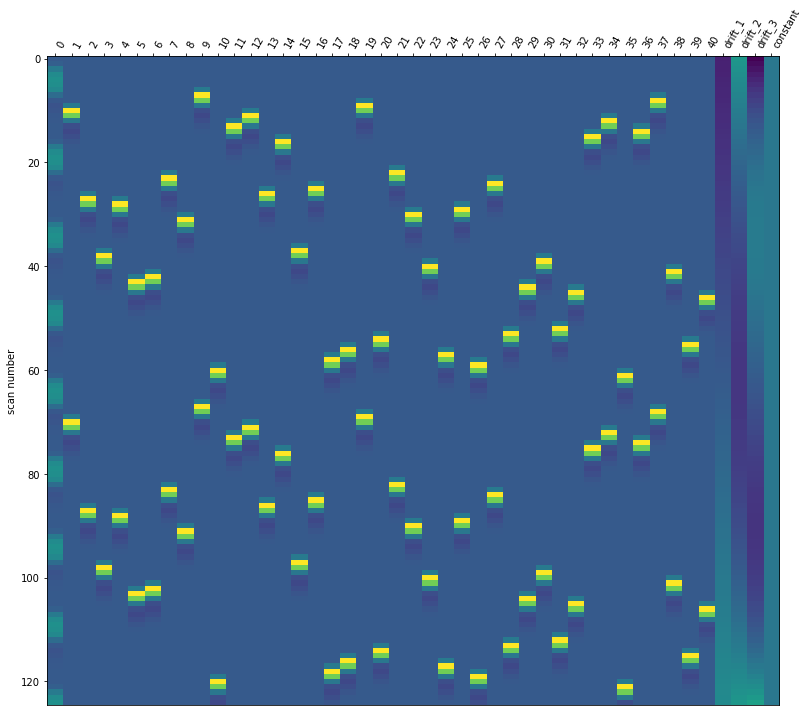

In [107]:
# Define the HRF function.
hrf_model='spm'

# Set the corresponding design matrix.
design_matrix = make_first_level_design_matrix(events_df['onset'], events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

In [147]:
events_bs=events_df.copy()
events_bs.drop(index=events_bs.index[-4:], 
        axis=0, 
        inplace=True)

print(events_bs)

     trial_type  onset  duration
0             0      0         3
1             0      3         3
2             0      6         3
3             0      9         3
4             0     12         3
..          ...    ...       ...
116          17    348         3
117          26    351         3
118          10    354         3
119          35    357         3
120           0    360         3

[121 rows x 3 columns]


In [148]:
events_bs['trial_type']=range(len(events_bs))

print(events_bs)

# Fit GLM models for all contrasts/predictors
print('Fitting a GLM')
fmri_glm = FirstLevelModel(t_r=tr, hrf_model='spm', mask_img=mask, drift_model=None)
fmri_glm.fit(func_data_pp, events_bs)

print(fmri_glm.design_matrices_)

     trial_type  onset  duration
0             0      0         3
1             1      3         3
2             2      6         3
3             3      9         3
4             4     12         3
..          ...    ...       ...
116         116    348         3
117         117    351         3
118         118    354         3
119         119    357         3
120         120    360         3

[121 rows x 3 columns]
Fitting a GLM
[              0         1         2         3    4    5    6    7    8    9  \
0.0    0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
3.0    0.098025  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
6.0    0.564368  0.098025  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
9.0    0.394139  0.564368  0.098025  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
12.0   0.088186  0.394139  0.564368  0.098025  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
360.0  0.000

In [149]:
fmri_glm.design_matrices_

[              0         1         2         3    4    5    6    7    8    9  \
 0.0    0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 3.0    0.098025  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 6.0    0.564368  0.098025  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 9.0    0.394139  0.564368  0.098025  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 12.0   0.088186  0.394139  0.564368  0.098025  0.0  0.0  0.0  0.0  0.0  0.0   
 ...         ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
 360.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 363.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 366.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 369.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 372.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 
        ...       112       113       

In [150]:
contrast_mat=np.eye(len(events_bs), len(events_bs)+1)
#contrast_mat[np.where(contrast_mat == 0)]=-1

print(contrast_mat)
print(contrast_mat.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(121, 122)


In [151]:
z_maps=[]

for contrast in contrast_mat:
    #print(contrast)
    #print(contrast.shape)
    z_maps.append(fmri_glm.compute_contrast(contrast))
    
print(len(z_maps))

121


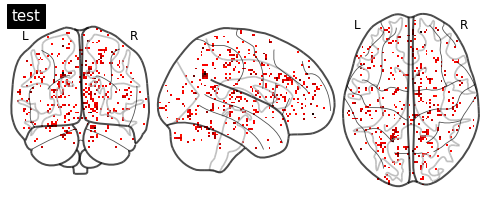

In [155]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_glass_brain(
    z_maps[6], threshold=3.0, title='test')
plotting.show()